# LeNet Implementation!

1. Create a LeNet Model
2. Feed in the Augmented data
3. Finalize!

### Import the necessary packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import string

import imghdr
from PIL import Image
from os import listdir


### Model

In [2]:
# Right now, this model is based on input size of 32 x 32. Must adjust kernels + padding + strides
# if we want to use a different input size
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 26)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Data handling

In [3]:
# Loads the images as list of png files based on the path
def loadImages(path):
    imagesList = listdir(path)
    imgs = []
    labels = []
    for image in imagesList:
      if imghdr.what(path + image) == 'png':
        if (image[6].isalpha()): # only add 5 of each image, only add alphabetical values
          img = Image.open(path + image)
          imgs.append(img)
          labels.append(ord(image[6]) - ord('a')) # assumes that filename structure is 'handx_[label]_....'
    return imgs, labels


# Process the data given input and output images. LeNet assumes input of 32. Resize is hyperparameter based on dataset.
def process_data(imgs, labels, batch_size=4, channels=3, resize=15, crop_size=32, test_split=0.2):
  transforms_array = applyTransforms(imgs, channels, crop_size, resize=resize)
  train_data, test_data, train_labels, test_labels = train_test_split(transforms_array, labels, test_size=test_split, random_state=42)
  [trainloader, testloader] = train_test_loaders(train_data, train_labels, test_data, test_labels, batch_size)
  return [trainloader, testloader]


# Reshape and Resize images
def applyTransforms(imgs, channels, crop_size, resize=15):
  # Define the necessary preprocessing transforms
  num_imgs = len(imgs)
  preprocess = transforms.Compose([
    transforms.Resize(resize), # Hyperparameter
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  ## Second, we must create the training and testing data. Format it so it's same as using CIFAR dataset
  transforms_array = np.zeros((num_imgs, channels, crop_size, crop_size))
  for i in range(num_imgs):
    temp = preprocess(imgs[i])
    transforms_array[i,:,:,:] = temp
  
  return transforms_array

  
def train_test_loaders(train_data, train_labels, test_data, test_labels, batch_size):
  ## Create the training dataand trainloader
  train_data_and_labels = []
  for i in range(len(train_data)):
    sample = (torch.Tensor(train_data[i,:,:,:]), train_labels[i])
    train_data_and_labels.append(sample)

  trainloader = torch.utils.data.DataLoader(train_data_and_labels, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

  ## Create the testing data and testloader
  test_data_and_labels = []
  for i in range(len(test_data)):
    sample = (torch.Tensor(test_data[i,:,:,:]), test_labels[i])
    test_data_and_labels.append(sample)

  testloader = torch.utils.data.DataLoader(test_data_and_labels, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
  return [trainloader, testloader]

def imshow(img):
  # Unnormalize the image before showing!
    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                        std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                        std = [ 1., 1., 1. ]),
                                  ])
    img = invTrans(img)
    print(img.shape)
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

def test_loader(imgs, labels, batch_size=4, channels=3, resize=15, crop_size=32):
    ## Create the testing data and testloader
    transforms_array = applyTransforms(imgs, channels, crop_size, resize=resize)
    
    test_data_and_labels = []
    for i in range(len(transforms_array)):
      sample = (torch.Tensor(transforms_array[i,:,:,:]), labels[i])
      test_data_and_labels.append(sample)

    testloader = torch.utils.data.DataLoader(test_data_and_labels, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    return testloader



In [4]:
def train_model(trainloader, criterion, optimizer, model, num_images, n=20):

  print_schedule = num_images // 5
  for epoch in range(n):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data


          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % print_schedule == (print_schedule-1):    # print every 200 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
              running_loss = 0.0

  print('Finished Training')
  return model


def test_model(testloader, model):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

    return correct, total

def show_true_vs_predicted(testloader, classes, model):
    # print images
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                                for j in range(4)))



# Model Training: Data without Augmentation

In [5]:
## Step 1: Declare the model and associated classes
lenet_no_aug = LeNet()
classes = list(string.ascii_uppercase)

# Step 2: Create the trainloader and testloader instances
path = "./Data_full/"
imgs, labels = loadImages(path)
num_images = len(imgs)
print(f"Total number of images in Dataset is: {num_images}")

[trainloader, testloader] = process_data(imgs, labels, crop_size=32)

Total number of images in Dataset is: 650


torch.Size([3, 36, 138])


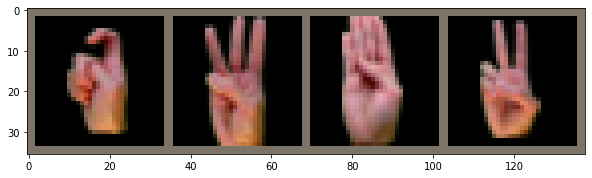

labels: X     W     B     V    


In [6]:
# Step 3: Visualize how some of the images look after processing the data
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
# print labels
print("labels: " + ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [7]:
# Step 4: Declare the loss function and optimizer for training
lr = 0.001  # Too large suboptimal convergence. Too small is process gets stuck. Find a balance
momentum = 0.9 # Standard should be close to 1

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet_no_aug.parameters(), lr=lr, momentum=momentum)

In [8]:
train_model(trainloader, criterion, optimizer, lenet_no_aug, num_images=num_images, n=25);

[1,   130] loss: 21.155
[2,   130] loss: 20.906
[3,   130] loss: 19.052
[4,   130] loss: 14.289
[5,   130] loss: 9.276
[6,   130] loss: 6.689
[7,   130] loss: 4.624
[8,   130] loss: 3.437
[9,   130] loss: 2.797
[10,   130] loss: 1.838
[11,   130] loss: 1.384
[12,   130] loss: 1.110
[13,   130] loss: 0.660
[14,   130] loss: 1.170
[15,   130] loss: 0.725
[16,   130] loss: 0.772
[17,   130] loss: 0.259
[18,   130] loss: 0.354
[19,   130] loss: 0.211
[20,   130] loss: 0.293
[21,   130] loss: 1.299
[22,   130] loss: 0.171
[23,   130] loss: 0.057
[24,   130] loss: 0.038
[25,   130] loss: 0.031
Finished Training


In [9]:
correct, total = test_model(testloader, lenet_no_aug);

print(f"Correct: {correct} \n Total: {total}")

Accuracy of the network on the 130 test images: 100 %
Correct: 130 
 Total: 130


torch.Size([3, 36, 138])


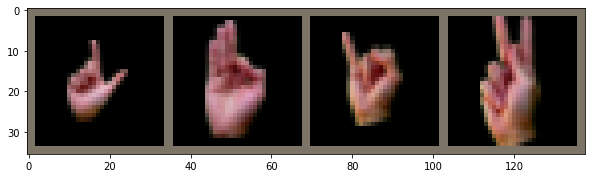

GroundTruth:  L     F     I     K    
Predicted:  L     F     I     K    


In [10]:
classes = list(string.ascii_uppercase)
show_true_vs_predicted(testloader, classes, lenet_no_aug)

In [11]:
# Save the model!
torch.save(lenet_no_aug.state_dict(), "./models/lenet_no_aug_650")

## Part 2: Apply on Data Augmentation Set

In [12]:
## Step 1: Declare the model and associated classes
lenet_with_aug = LeNet()
classes = list(string.ascii_uppercase)

In [13]:
# Step 2: Create the trainloader and testloader instances
path = "./FinalImages/"
imgs, labels = loadImages(path)
num_images = len(imgs)
print(f"Total number of images in Dataset is: {num_images}")

[trainloader, testloader] = process_data(imgs, labels, resize=35, crop_size=32) # note: had to adjust resize b/c assumes 600x600 now

Total number of images in Dataset is: 3900


torch.Size([3, 36, 138])


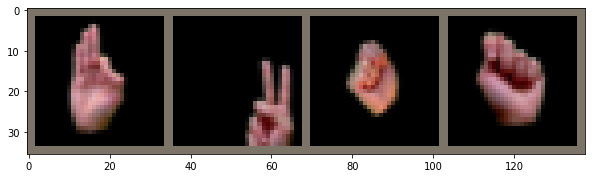

labels: F     V     N     T    


In [14]:
# Step 3: Visualize how some of the images look after processing the data
dataiter = iter(trainloader)
images, labels = dataiter.next()
batch_size = 4

imshow(torchvision.utils.make_grid(images))
# print labels
print("labels: " + ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [15]:
# Step 4: Declare the loss function and optimizer for training
lr = 0.001  # Too large suboptimal convergence. Too small is process gets stuck. Find a balance
momentum = 0.9 # Standard should be close to 1

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet_with_aug.parameters(), lr=lr, momentum=momentum)

In [16]:
train_model(trainloader, criterion, optimizer, lenet_with_aug, num_images, n=25)

[1,   780] loss: 126.444
[2,   780] loss: 101.732
[3,   780] loss: 67.567
[4,   780] loss: 48.742
[5,   780] loss: 35.894
[6,   780] loss: 27.244
[7,   780] loss: 19.899
[8,   780] loss: 16.255
[9,   780] loss: 12.649
[10,   780] loss: 10.430
[11,   780] loss: 8.706
[12,   780] loss: 5.792
[13,   780] loss: 5.177
[14,   780] loss: 5.761
[15,   780] loss: 2.811
[16,   780] loss: 4.403
[17,   780] loss: 2.795
[18,   780] loss: 1.912
[19,   780] loss: 3.585
[20,   780] loss: 1.786
[21,   780] loss: 5.299
[22,   780] loss: 1.239
[23,   780] loss: 0.163
[24,   780] loss: 0.049
[25,   780] loss: 0.031
Finished Training


LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=26, bias=True)
)

In [17]:
correct, total = test_model(testloader, lenet_with_aug)

print(f"Correct: {correct} \n Total: {total}")

Accuracy of the network on the 780 test images: 87 %
Correct: 686 
 Total: 780


torch.Size([3, 36, 138])


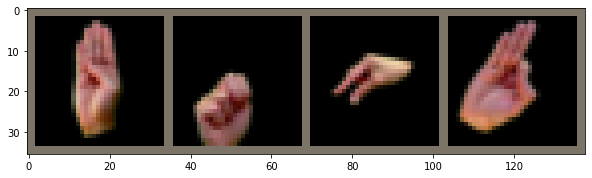

GroundTruth:  B     N     Q     F    
Predicted:  B     N     Q     F    


In [18]:
classes = list(string.ascii_uppercase)
show_true_vs_predicted(testloader, classes, lenet_with_aug)

In [19]:
# Save the model!
torch.save(lenet_with_aug.state_dict(), "./models/lenet_with_aug_3900")

### Part 3: Compare each model (trained with vs without augmented data) on newly augmented data

In [20]:
path = './Mult_Augments/'

test_imgs, test_labels = loadImages(path)

testloader = test_loader(test_imgs, test_labels, resize=35)

torch.Size([3, 36, 138])


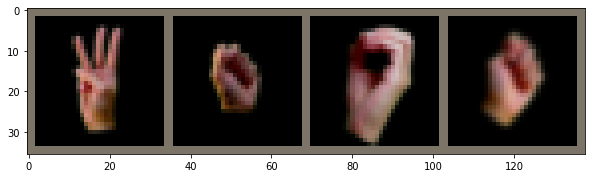

labels: W     S     O     T    


In [21]:
# Step 1: Visualize how some of the images look after processing the data
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
# print labels
print("labels: " + ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [22]:
lenet_no_aug = LeNet()
lenet_no_aug.load_state_dict(torch.load("./models/lenet_no_aug_650"))
lenet_no_aug.eval()

test_model(testloader, lenet_no_aug)

Accuracy of the network on the 650 test images: 32 %


(211, 650)

In [23]:
lenet_with_aug = LeNet()
lenet_with_aug.load_state_dict(torch.load("./models/lenet_with_aug_3900"))
lenet_with_aug.eval()

test_model(testloader, lenet_with_aug)

Accuracy of the network on the 650 test images: 69 %


(450, 650)

### Trish Fish Second Folder

In [24]:
path = './Only_Mult_Augments/'

test_imgs, test_labels = loadImages(path)

testloader = test_loader(test_imgs, test_labels, resize=35)

In [25]:
lenet_no_aug = LeNet()
lenet_no_aug.load_state_dict(torch.load("./models/lenet_no_aug_650"))
lenet_no_aug.eval()

test_model(testloader, lenet_no_aug)

Accuracy of the network on the 650 test images: 17 %


(112, 650)

In [26]:
lenet_with_aug = LeNet()
lenet_with_aug.load_state_dict(torch.load("./models/lenet_with_aug_3900"))
lenet_with_aug.eval()

test_model(testloader, lenet_with_aug)

Accuracy of the network on the 650 test images: 57 %


(374, 650)